<a href="https://colab.research.google.com/github/Sanhyaran123/Trader-Behavior-vs-market-sentiment-analysis/blob/main/trader_behavior_vs_market_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install gdown --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [40]:
traders=pd.read_csv('/content/sample_data/historical_data.csv',low_memory=False)

In [41]:
sent=pd.read_csv('/content/sample_data/fear_greed_index.csv',low_memory=False)

In [42]:
print("Traders shape:",traders.shape)
print("Sent shape:",sent.shape)

Traders shape: (211224, 16)
Sent shape: (2644, 4)


In [43]:
display(traders.head())
display(sent.head())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [44]:
# Reload the sentiment data
sent=pd.read_csv('/content/sample_data/fear_greed_index.csv',low_memory=False)

# Traders datetime processing
traders['time'] = pd.to_datetime(traders['Timestamp IST'], errors='coerce')
traders.dropna(subset=['time'], inplace=True)
traders['date'] = pd.to_datetime(traders['time'].dt.date)

# Sentiment datetime processing
sent = sent.drop(sent.columns[0], axis=1) # Drop the first column
sent.rename(columns={'classification': 'sentiment'}, inplace=True)
sent['sentiment'] = sent['sentiment'].str.strip().str.title()
sent['date'] = pd.to_datetime(sent['date'], errors='coerce')

In [45]:
for col in ['Execution Price', 'Size USD', 'Closed PnL', 'Start Position']:
    if col in traders.columns:
        traders[col] = pd.to_numeric(traders[col], errors='coerce')

traders['side_norm'] = traders['Side'].astype(str).str.lower()

agg = traders.groupby('date').agg(
    total_trades=('Account', 'count'),
    total_volume=('Size USD', lambda x: x.abs().sum()),
    avg_size=('Size USD', 'mean'),
    win_trades=('Closed PnL', lambda x: (x > 0).sum()),
    lose_trades=('Closed PnL', lambda x: (x < 0).sum()),
    avg_closedPnL=('Closed PnL', 'mean'),
    total_closedPnL=('Closed PnL', 'sum'),
).reset_index()

agg['win_rate'] = agg['win_trades'] / agg['total_trades']
agg['loss_rate'] = agg['lose_trades'] / agg['total_trades']

In [46]:
df = pd.merge(agg, sent[['date', 'sentiment']], on='date', how='left')
df['sentiment'].fillna('Unknown', inplace=True)

df.head()

/tmp/ipython-input-1790762069.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].fillna('Unknown', inplace=True)


,date,total_trades,total_volume,avg_size,win_trades,lose_trades,avg_closedPnL,total_closedPnL,win_rate,loss_rate,sentiment
0,2023-01-05,3,477.00,159.000000,0,0,0.000000,0.000000,0.000000,0.000000,Fear
1,2023-05-12,9,50005.83,5556.203333,0,0,0.000000,0.000000,0.000000,0.000000,Neutral
2,2024-01-01,18,264239.53,14679.973889,1,5,-7.196192,-129.531460,0.055556,0.277778,Greed
3,2024-01-02,6,2008.18,334.696667,0,0,0.000000,0.000000,0.000000,0.000000,Greed
4,2024-01-03,137,472974.70,3452.370073,128,0,60.176945,8244.241409,0.934307,0.000000,Greed


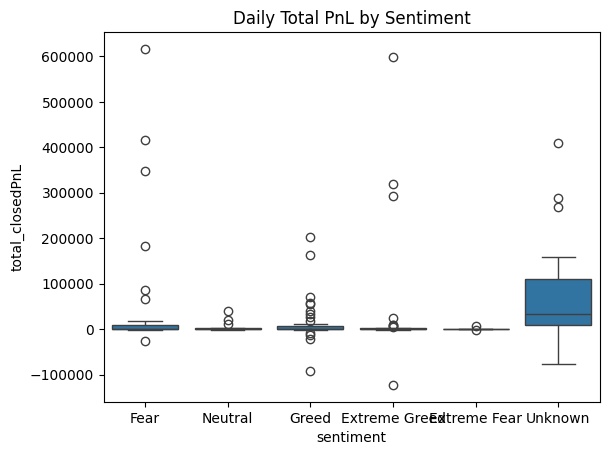

In [47]:
sns.boxplot(x='sentiment', y='total_closedPnL', data=df)
plt.title('Daily Total PnL by Sentiment')
plt.show()

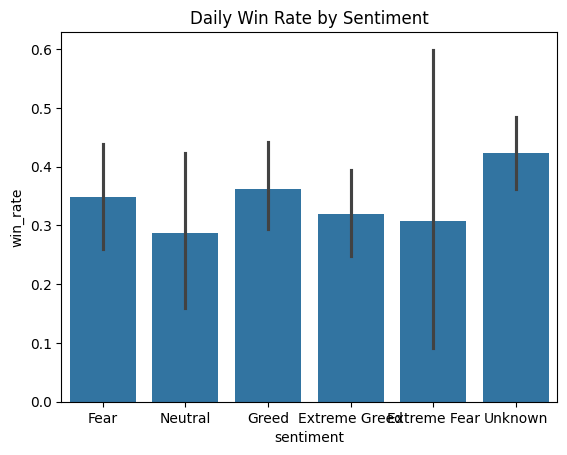

In [48]:
sns.barplot(x='sentiment', y='win_rate', data=df)
plt.title('Daily Win Rate by Sentiment')
plt.show()

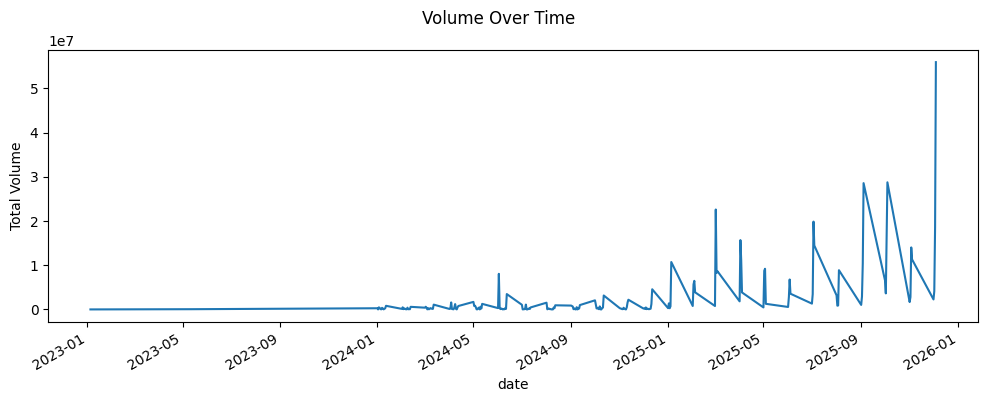

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x='date', y='total_volume', ax=ax, legend=False)
ax.set_ylabel('Total Volume')
plt.suptitle('Volume Over Time')
plt.show()

In [50]:
grp_greed = df[df['sentiment'] == 'Greed']['total_closedPnL'].dropna()
grp_fear = df[df['sentiment'] == 'Fear']['total_closedPnL'].dropna()

t_res = stats.ttest_ind(grp_greed, grp_fear, equal_var=False, nan_policy='omit')
mw_res = stats.mannwhitneyu(grp_greed, grp_fear, alternative='two-sided')

print("T-test:", t_res)
print("Mann-Whitney:", mw_res)

T-test: TtestResult(statistic=np.float64(-1.6542907215642328), pvalue=np.float64(0.10585133025087051), df=np.float64(40.229618413773615))
Mann-Whitney: MannwhitneyuResult(statistic=np.float64(945.5), pvalue=np.float64(0.4787979897718182))


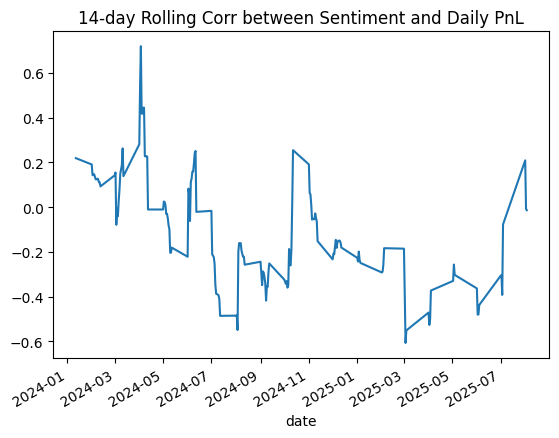

In [51]:
df['sent_num'] = df['sentiment'].map({'Greed': 1, 'Fear': -1}).fillna(0)
rolling_corr = df.set_index('date')['sent_num'].rolling(14).corr(df.set_index('date')['total_closedPnL'])

rolling_corr.plot(title='14-day Rolling Corr between Sentiment and Daily PnL')
plt.show()

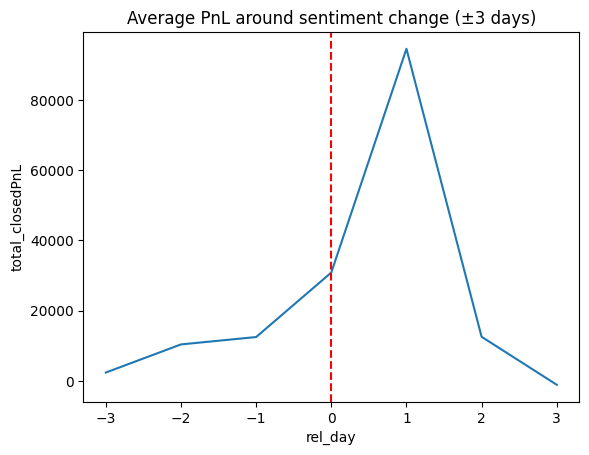

In [52]:
# Sort and detect sentiment change days
df = df.sort_values('date')
df['sent_shift'] = df['sentiment'] != df['sentiment'].shift(1)
change_days = df[df['sent_shift'] & df['sentiment'].isin(['Greed', 'Fear'])]['date']

# Collect data ±3 days around each change
events = []
window = 3
for d in change_days:
    mask = (df['date'] >= d - pd.Timedelta(days=window)) & (df['date'] <= d + pd.Timedelta(days=window))
    subset = df.loc[mask, ['date', 'total_closedPnL']].copy()
    subset['event_center'] = d
    events.append(subset)

events_df = pd.concat(events)
events_df['rel_day'] = (events_df['date'] - events_df['event_center']).dt.days

# Average PnL by relative day
events_mean = events_df.groupby('rel_day')['total_closedPnL'].mean().reset_index()

sns.lineplot(x='rel_day', y='total_closedPnL', data=events_mean)
plt.axvline(0, color='red', linestyle='--')
plt.title('Average PnL around sentiment change (±3 days)')
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Keep only rows with known sentiment
df_model = df[df['sentiment'].isin(['Greed', 'Fear'])].copy()
X = df_model[['total_volume', 'win_rate', 'avg_size']].fillna(0)
y = df_model['sentiment'].map({'Greed': 1, 'Fear': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.375
              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.47      0.57      0.52        14

    accuracy                           0.38        24
   macro avg       0.31      0.34      0.32        24
weighted avg       0.33      0.38      0.35        24

